In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, TensorDataset
from PIL import Image
from torchsummary import summary
import torchvision.models as models

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def PlotLearningCurve(epoch, trainingloss, testingloss=None):
    plt.plot(trainingloss, label='training loss')
    # plt.plot(testingloss, label='testing loss')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim()
    plt.ylim()
    plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls drive/My\ Drive/Colab\ Notebooks/

HM.ipynb       params160.pkl  params30.pkl  result_160
params10.pkl   params170.pkl  params40.pkl  Test1
params140.pkl  params180.pkl  params50.pkl  Train1
params150.pkl  params20.pkl   result	    Untitled0.ipynb


In [0]:
import os
os.chdir('drive/My Drive/Colab Notebooks/')

In [0]:
!ls

HM.ipynb       params160.pkl  params30.pkl  result_160
params10.pkl   params170.pkl  params40.pkl  Test1
params140.pkl  params180.pkl  params50.pkl  Train1
params150.pkl  params20.pkl   result	    Untitled0.ipynb


In [0]:
import os
def get_data(data_name, flag):
    if flag == 'train':
        label_path = "Train1/" + data_name + '/' #dir root
        data_path = 'Train1/original_retinal_images_pre/'
    else:
        label_path = "Test1/" + data_name + '/' #dir root
        data_path = 'Test1/original_retinal_images_pre/'
    # get data
    datas = []
    labels = []
    files= sorted(os.listdir(label_path)) #get all img name
    for file_name in files: #遍历文件夹
#         print(file_name)
        if not os.path.isdir(file_name) and file_name[0]!='.': #判断是否是文件夹，不是文件夹才打开
            label = cv2.imread(label_path + file_name, 0)
            data = cv2.imread(data_path + file_name[:-7] + '.jpg')
            datas.append(data)
            labels.append(label)
    datas = np.array(datas)
    labels = np.array(labels)
#     print(labels.shape)
#     TensorDataset = torch.utils.data.TensorDataset(torch.tensor(labels), torch.tensor(datas))
    return datas, labels
            
#     # Each image is divided 255 to bound values onto [0,1].
#     img_nor = img_640/255
#     # In case of HE and MA, each image is divided by 255 and then subtracted with the mean.
#     img_res = img_nor - np.mean(img_nor)

In [0]:
datas,labels = get_data("masks_Haemorrhages_pre",'train')
datas_nor = torch.tensor(datas/255)
labels_nor = torch.tensor(labels)
datas_nor = datas_nor.permute(0,3,1,2)
labels_nor = labels_nor.view(labels.shape[0],1,640,640)
# datas_nor.shape, labels_nor.shape
train_data = torch.utils.data.TensorDataset(datas_nor.type('torch.DoubleTensor'), labels_nor.type('torch.DoubleTensor'))
train_loader =  torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=False)

In [0]:
datas,labels = get_data("masks_Haemorrhages_pre",'test')
datas_nor = torch.tensor(datas/255)
labels_nor = torch.tensor(labels)
datas_nor = datas_nor.permute(0,3,1,2)
labels_nor = labels_nor.view(labels.shape[0],1,640,640)
# datas_nor.shape, labels_nor.shape
test_data = torch.utils.data.TensorDataset(datas_nor.type('torch.DoubleTensor'), labels_nor.type('torch.DoubleTensor'))
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False)

In [0]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch), #添加了BN层
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class OneConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OneConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch), #添加了BN层
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.conv1 = DoubleConv(3, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(256, 512)
        self.pool5 = nn.MaxPool2d(2)
        self.conv6 = DoubleConv(512, 512)
        self.pool6 = nn.MaxPool2d(2)
        self.conv7 = DoubleConv(512, 512)
        # 逆卷积，也可以使用上采样
        self.up1 = nn.Upsample(20)
        self.conv8 = OneConv(512, 512)
        self.conv9 = DoubleConv(1024, 512)
        self.up2 = nn.Upsample(40)
        self.conv10 = OneConv(512, 512)
        self.conv11 = DoubleConv(1024, 512)
        self.up3 = nn.Upsample(80)
        self.conv12 = OneConv(512, 256)
        self.conv13 = DoubleConv(512, 256)
        self.up4 = nn.Upsample(160)
        self.conv14 = OneConv(256, 128)
        self.conv15 = DoubleConv(256, 128)
        self.up5 = nn.Upsample(320)
        self.conv16 = OneConv(128, 64)
        self.conv17 = DoubleConv(128, 64)
        self.up6 = nn.Upsample(640)
        self.conv18 = OneConv(64, 32)
        self.conv19 = DoubleConv(64, 32)
        self.conv20 = nn.Sequential(
            nn.Conv2d(32, 1, 1, 1, 0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        p5 = self.pool5(c5)
        c6 = self.conv6(p5)
        p6 = self.pool6(c6)
        c7 = self.conv7(p6)
        u1 = self.up1(c7)
        c8 = self.conv8(u1)
        concat1 = torch.cat([c8, c6], dim=1)
        c9 = self.conv9(concat1)
        u2 = self.up2(c9)
        c10 = self.conv10(u2)
        concat2 = torch.cat([c10, c5], dim=1)
        c11 = self.conv11(concat2)
        u3 = self.up3(c11)
        c12 = self.conv12(u3)
        concat3 = torch.cat([c12, c4], dim=1)
        c13 = self.conv13(concat3)
        u4 = self.up4(c13)
        c14 = self.conv14(u4)
        concat4 = torch.cat([c14, c3], dim=1)
        c15 = self.conv15(concat4)
        u5 = self.up5(c15)
        c16 = self.conv16(u5)
        concat5 = torch.cat([c16, c2], dim=1)
        c17 = self.conv17(concat5)
        u6 = self.up6(c17)
        c18 = self.conv18(u6)
        concat6 = torch.cat([c18, c1], dim=1)
        c19 = self.conv19(concat6)
        out = self.conv20(c19)
        return out

In [0]:
class NNModel:
    def __init__(self, network, learning_rate, train_loader, test_loader):
        self.trainloader = train_loader
        self.testloader = test_loader
        self.model = network
        self.lossfn = nn.BCEWithLogitsLoss(reduction='mean')
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, betas=(0.5,0.999))
        self.num_train_samples = len(self.trainloader)
        self.num_test_samples = len(self.testloader)
        self.trainingloss = []

    def train_epoch(self):
        self.model.train()
        loss_=0
        epoch_size = 0
        for images, labels in self.trainloader:
          self.optimizer.zero_grad()
          images=images.cuda()
          labels=labels.cuda()
          log_ps = self.model(images)
          epoch_size += images.size(0)
          # weight1 = ((labels[0]==0).sum()/(labels[0]!=0).sum()/8).type('torch.DoubleTensor')
          # weight2 = ((labels[1]==0).sum()/(labels[1]!=0).sum()/8).type('torch.DoubleTensor')
          # list_weight = [weight1,weight2]
          # self.lossfn.weight = torch.tensor(list_weight).cuda()
          # self.lossfn.weight = ((labels==0).sum()/(labels!=0).sum()/8).type('torch.DoubleTensor').cuda()
          # print(self.lossfn.weight, self.lossfn.weight.shape)
          # print(log_ps.shape, labels.shape)
          loss = self.lossfn(log_ps, labels)
          loss.backward()
          self.optimizer.step()
          loss_+=loss.item()
          # self.trainingloss.append(loss.item())
        loss_ /= epoch_size
        return loss_

    
    def eval(self):
        self.model.eval()
        num = 0
        with torch.no_grad():
          for images, labels in self.testloader:
            images = images.cuda()
            labels = labels.cuda()
            result = self.model(images)
            print(result.shape, torch.max(result))
            for i in range(result.shape[0]):
              b = result[i].squeeze().view(640,640,1)
              print(b.shape, torch.max(b), type(b))
              b=b/torch.max(b)*255
              result_img=torchvision.transforms.ToPILImage()(np.uint8(b.cpu()))
              result_img.save('result/' + str(num) + '.jpg')
              num+=1



In [0]:
import time
start = time.time()
# Define your learning rate
learning_rate = 2e-4
# train
m = NNModel(Unet().double().cuda(), learning_rate, train_loader, test_loader)
m.model.load_state_dict(torch.load('params80.pkl'))
epochs = 150
loss_c = []

for e in range(81,epochs+1):
    loss_c.append(m.train_epoch())
    if e%10==0:
      torch.save(m.model.state_dict(), 'params' + str(e) + '.pkl')
    print(e)
print(time.time()-start)

81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
5594.841672182083


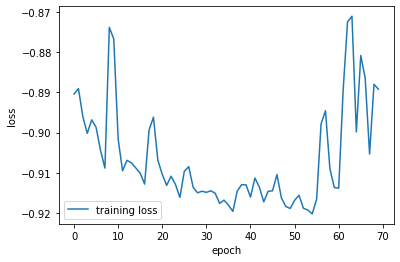

6441.729838371277


In [0]:
PlotLearningCurve(epochs, loss_c)
end = time.time()
print(end-start)

In [0]:
learning_rate = 2e-5
mm = NNModel(Unet().double().cuda(), learning_rate, train_loader, test_loader)
mm.model.load_state_dict(torch.load('params150.pkl'))

mm.eval()
end = time.time()
print(end-start)

torch.Size([2, 1, 640, 640]) tensor(1.0000, device='cuda:0', dtype=torch.float64)
torch.Size([640, 640, 1]) tensor(1.0000, device='cuda:0', dtype=torch.float64) <class 'torch.Tensor'>
torch.Size([640, 640, 1]) tensor(1.0000, device='cuda:0', dtype=torch.float64) <class 'torch.Tensor'>
torch.Size([2, 1, 640, 640]) tensor(1.0000, device='cuda:0', dtype=torch.float64)
torch.Size([640, 640, 1]) tensor(1.0000, device='cuda:0', dtype=torch.float64) <class 'torch.Tensor'>
torch.Size([640, 640, 1]) tensor(1.0000, device='cuda:0', dtype=torch.float64) <class 'torch.Tensor'>
torch.Size([2, 1, 640, 640]) tensor(1.0000, device='cuda:0', dtype=torch.float64)
torch.Size([640, 640, 1]) tensor(1.0000, device='cuda:0', dtype=torch.float64) <class 'torch.Tensor'>
torch.Size([640, 640, 1]) tensor(1.0000, device='cuda:0', dtype=torch.float64) <class 'torch.Tensor'>
torch.Size([2, 1, 640, 640]) tensor(1.0000, device='cuda:0', dtype=torch.float64)
torch.Size([640, 640, 1]) tensor(1.0000, device='cuda:0', dt

In [0]:
x=Unet().cuda()
summary(x,input_size=(3,640,640), device='cuda')

NameError: ignored

In [0]:
# import torch
# target = torch.ones([10,1, 64,64], dtype=torch.float32)  # 64 classes, batch size = 10
# output = torch.full([10, 1,64, 64], 0.999)  # A prediction (logit)
# pos_weight = torch.tensor([64])  # All weights are equal to 1
# criterion = torch.nn.BCEWithLogitsLoss(weight=pos_weight)
# criterion(output, target)  # -log(sigmoid(0.999))